In [3]:
import os
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.fftpack import fft, ifft, dct
from python_speech_features import logfbank
from pydub import AudioSegment
from gammatone.gtgram import gtgram
import tempfile
import warnings
warnings.filterwarnings("ignore")

# Load Data

In [4]:
major_dir = 'audio_files/Major'
minor_dir = 'audio_files/Minor'
output_csv = 'audio_data.csv'

def load_audio_files(directory, label):
    files = []
    for file_name in os.listdir(directory):
        if file_name.endswith('.wav'):
            files.append({
                'file_path': os.path.join(directory, file_name),
                'label': label
            })
    return files

major_files = load_audio_files(major_dir, 0)  # 0 for major
minor_files = load_audio_files(minor_dir, 1)  # 1 for minor

all_files = major_files + minor_files
df = pd.DataFrame(all_files)

# Save to CSV
df.to_csv(output_csv, index=False)


In [5]:
df


,file_path,label
0,audio_files/Major/Major_500.wav,0
1,audio_files/Major/Major_266.wav,0
2,audio_files/Major/Major_272.wav,0
3,audio_files/Major/Major_299.wav,0
4,audio_files/Major/Major_474.wav,0
...,...,...
854,audio_files/Minor/Minor_215.wav,1
855,audio_files/Minor/Minor_201.wav,1
856,audio_files/Minor/Minor_229.wav,1
857,audio_files/Minor/Minor_23.wav,1


In [10]:
def add_noise(y, noise_factor=0.005):
    noise = np.random.randn(len(y))
    augmented_data = y + noise_factor * noise
    return augmented_data

def change_pitch(y, sr, pitch_factor=2.0):
    return librosa.effects.pitch_shift(y, sr=sr, n_steps=pitch_factor)

def stretch_audio(y, rate=0.8):
    return librosa.effects.time_stretch(y, rate=rate)

def augment_audio(y, sr):
    augmented_y = []
    augmented_y.append(add_noise(y))
    augmented_y.append(change_pitch(y, sr))
    augmented_y.append(stretch_audio(y))
    return augmented_y

In [15]:
import soundfile as sf

def save_augmented_audio(y, sr, augmentations, label):
    augmented_files = []
    for i, augmented in enumerate(augmentations):
        temp_file = tempfile.NamedTemporaryFile(delete=False, suffix='.wav')
        sf.write(temp_file.name, augmented, sr)
        augmented_files.append({
            'file_path': temp_file.name,
            'label': label
        })
    return augmented_files

augmented_data = []

for index, row in df.iterrows():
    y, sr = librosa.load(row['file_path'], sr=None)
    augmentations = augment_audio(y, sr)
    augmented_files = save_augmented_audio(y, sr, augmentations, row['label'])
    augmented_data.extend(augmented_files)

augmented_df = pd.DataFrame(augmented_data)
combined_df = pd.concat([df, augmented_df])

# Save combined data to CSV
combined_df.to_csv(output_csv, index=False)

In [16]:
combined_df

,file_path,label
0,audio_files/Major/Major_500.wav,0
1,audio_files/Major/Major_266.wav,0
2,audio_files/Major/Major_272.wav,0
3,audio_files/Major/Major_299.wav,0
4,audio_files/Major/Major_474.wav,0
...,...,...
2572,/var/folders/b1/frm8p4wx2v1_r2r5qhspvnm80000gn...,1
2573,/var/folders/b1/frm8p4wx2v1_r2r5qhspvnm80000gn...,1
2574,/var/folders/b1/frm8p4wx2v1_r2r5qhspvnm80000gn...,1
2575,/var/folders/b1/frm8p4wx2v1_r2r5qhspvnm80000gn...,1


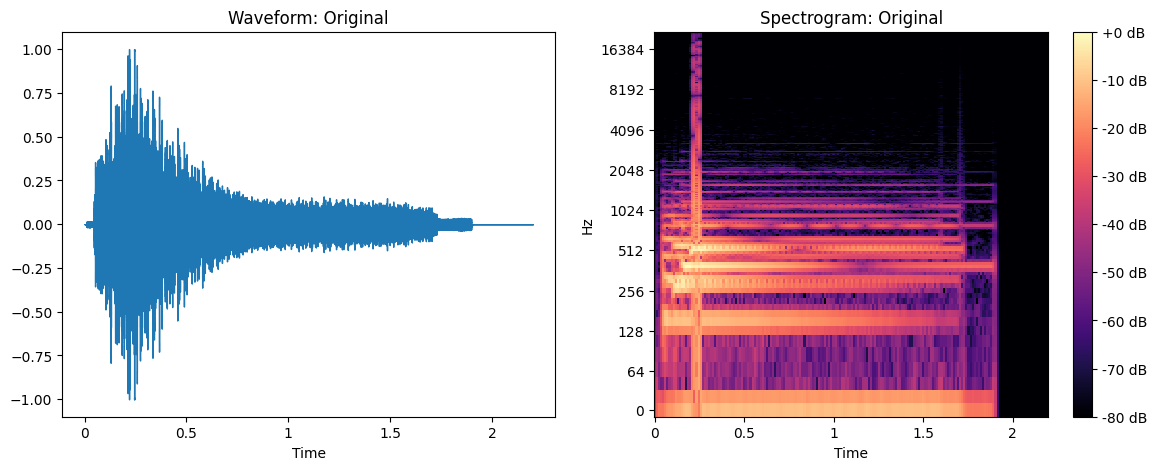

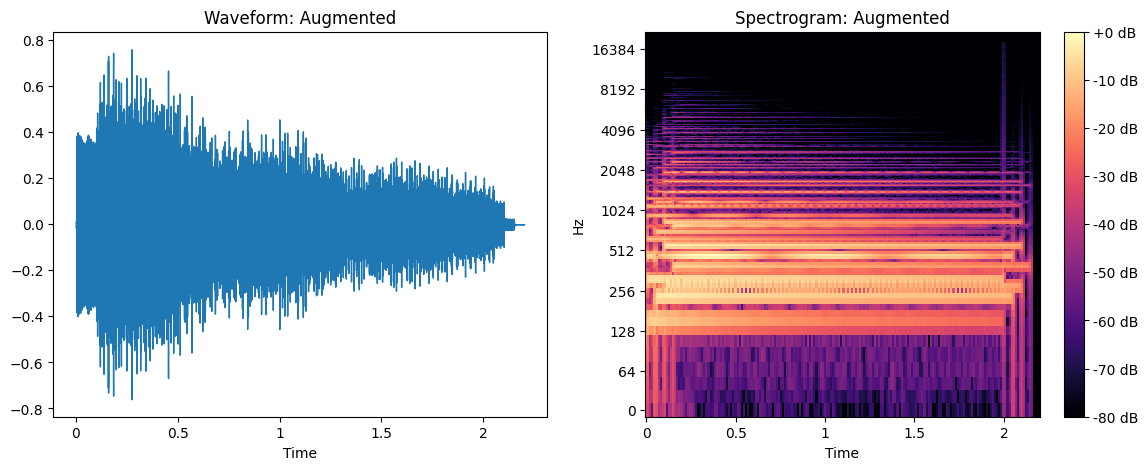

In [19]:
import librosa.display
import matplotlib.pyplot as plt
import IPython.display as ipd
import random

def plot_waveform_and_spectrogram(file_path, title):
    y, sr = librosa.load(file_path, sr=None)
    plt.figure(figsize=(14, 5))
    
    plt.subplot(1, 2, 1)
    librosa.display.waveshow(y, sr=sr)
    plt.title(f'Waveform: {title}')
    
    plt.subplot(1, 2, 2)
    D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
    librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log')
    plt.title(f'Spectrogram: {title}')
    plt.colorbar(format='%+2.0f dB')
    
    plt.show()

# Load and plot a random original and augmented file
original_file = combined_df[combined_df['label'] == 0].sample(1)['file_path'].values[0]
augmented_file = combined_df[combined_df['label'] == 0].sample(1)['file_path'].values[0]

plot_waveform_and_spectrogram(original_file, 'Original')
plot_waveform_and_spectrogram(augmented_file, 'Augmented')


In [20]:
def play_audio(file_path):
    y, sr = librosa.load(file_path, sr=None)
    return ipd.Audio(data=y, rate=sr)

# Play original and augmented audio
print("Original Audio:")
ipd.display(play_audio(original_file))

print("Augmented Audio:")
ipd.display(play_audio(augmented_file))


Original Audio:


Augmented Audio:


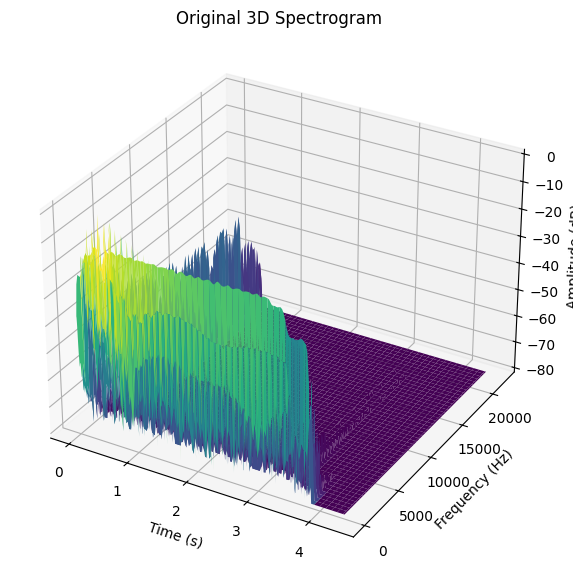

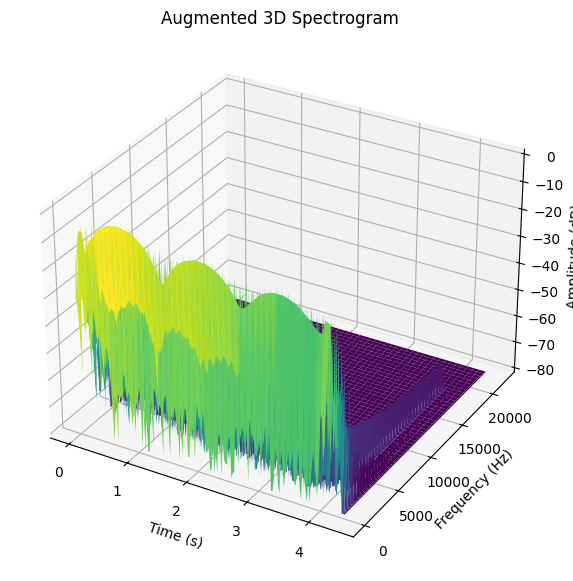

In [22]:
# Function to plot 3D spectrogram
def plot_3d_spectrogram(file_path, title):
    y, sr = librosa.load(file_path, sr=None)
    S = np.abs(librosa.stft(y))**2
    S_dB = librosa.power_to_db(S, ref=np.max)
    
    fig = plt.figure(figsize=(14, 7))
    ax = fig.add_subplot(111, projection='3d')
    
    # Get the time and frequency axes
    times = librosa.times_like(S_dB)
    freqs = librosa.fft_frequencies(sr=sr)
    
    # Create a meshgrid for the time and frequency axes
    T, F = np.meshgrid(times, freqs)
    
    # Plot the surface
    ax.plot_surface(T, F, S_dB, cmap='viridis')
    
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Frequency (Hz)')
    ax.set_zlabel('Amplitude (dB)')
    ax.set_title(title)
    
    plt.show()

# Plotting and playing audio
plot_3d_spectrogram(original_file, 'Original 3D Spectrogram')
plot_3d_spectrogram(augmented_file, 'Augmented 3D Spectrogram')

In [76]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

class AudioDataset(Dataset):
    def __init__(self, csv_file, max_length, transform=None):
        self.data = pd.read_csv(csv_file)
        self.max_length = max_length
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        audio_path = self.data.iloc[idx]['file_path']
        label = self.data.iloc[idx]['label']
        waveform, sr = torchaudio.load(audio_path)
        waveform = pad_trim(waveform, self.max_length)
        if self.transform:
            waveform = self.transform(waveform)
        return waveform, label

def collate_fn(batch):
    waveforms, labels = zip(*batch)
    waveforms = torch.stack(waveforms)  # Ensure the waveforms have the correct shape
    labels = torch.tensor(labels)
    return waveforms, labels

def pad_trim(waveform, max_length):
    if waveform.shape[1] > max_length:
        # Trim the waveform
        waveform = waveform[:, :max_length]
    elif waveform.shape[1] < max_length:
        # Pad the waveform
        padding = max_length - waveform.shape[1]
        waveform = torch.nn.functional.pad(waveform, (0, padding))
    return waveform

# Determine the maximum length in samples (e.g., 16000 samples per second * 10 seconds)
max_length = 16000 * 10  # 10 seconds
dataset = AudioDataset(output_csv, max_length=max_length)
data_loader = DataLoader(dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)

Using device: cpu


In [ ]:
def train_model(model, processor, data_loader, model_save_path, epochs=3):
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
    model.to(device)

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        correct_predictions = 0
        total_predictions = 0

        for batch in tqdm(data_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            waveforms = batch[0].to(device)
            inputs = processor(waveforms, sampling_rate=16000, return_tensors="pt", padding=True)
            input_values = inputs.input_values.squeeze().to(device)
            labels = batch[1].to(device)

            if 'attention_mask' in inputs:
                outputs = model(input_values=input_values, attention_mask=inputs.attention_mask.to(device), labels=labels)
            else:
                outputs = model(input_values=input_values, labels=labels)

            loss = outputs.loss
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            total_loss += loss.item()
            predictions = torch.argmax(outputs.logits, dim=-1)
            correct_predictions += (predictions == labels).sum().item()
            total_predictions += labels.size(0)

        accuracy = correct_predictions / total_predictions
        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(data_loader):.4f}, Accuracy: {accuracy:.4f}")

    # Save the model
    torch.save(model.state_dict(), model_save_path)
    print(f"Model saved to {model_save_path}")


# Instantiate the models and processors
wav2vec_processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base")
wav2vec_model = Wav2Vec2ForSequenceClassification.from_pretrained("facebook/wav2vec2-base", num_labels=2)

wavlm_processor = Wav2Vec2FeatureExtractor.from_pretrained("microsoft/wavlm-base")
wavlm_model = WavLMForSequenceClassification.from_pretrained("microsoft/wavlm-base", num_labels=2)

# Train and save Wav2Vec model
train_model(wav2vec_model, wav2vec_processor, data_loader, "wav2vec")

# Train and save WavLM model
train_model(wavlm_model, wavlm_processor, data_loader, "wavlm")


Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of WavLMForSequenceClassification were not initialized from the model checkpoint at microsoft/wavlm-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1/3: 100%|██████████| 859/859 [1:37:25<00

Epoch 1/3, Loss: 0.6808, Accuracy: 0.5751


Epoch 2/3: 100%|██████████| 859/859 [1:39:37<00:00,  6.96s/it]


Epoch 2/3, Loss: 0.6807, Accuracy: 0.5844


Epoch 3/3:  21%|██        | 178/859 [11:51:52<1:24:12,  7.42s/it]    

In [75]:
def evaluate_model(model, processor, data_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():
        for batch in data_loader:
            waveforms = batch[0].to(device)
            inputs = processor(waveforms, sampling_rate=16000, return_tensors="pt", padding=True)
            input_values = inputs.input_values.squeeze().to(device)
            labels = batch[1].to(device)

            if 'attention_mask' in inputs:
                outputs = model(input_values=input_values, attention_mask=inputs.attention_mask.to(device))
            else:
                outputs = model(input_values=input_values)

            predictions = torch.argmax(outputs.logits, dim=-1)
            correct_predictions += (predictions == labels).sum().item()
            total_predictions += labels.size(0)

            print(f"Predicted: {predictions}, Actual: {labels}")

    accuracy = correct_predictions / total_predictions
    print(f"Accuracy: {accuracy:.4f}")

# Evaluate the Wav2Vec model
print("Evaluating Wav2Vec model")
evaluate_model(wav2vec_model, wav2vec_processor, data_loader)

# Evaluate the WavLM model
print("Evaluating WavLM model")
evaluate_model(wavlm_model, wavlm_processor, data_loader)

Evaluating Wav2Vec model
Predicted: tensor([0, 0, 0, 0]), Actual: tensor([1, 0, 0, 1])
Predicted: tensor([0, 0, 0, 1]), Actual: tensor([0, 0, 0, 0])
Predicted: tensor([0, 0, 0, 0]), Actual: tensor([0, 0, 1, 0])
Predicted: tensor([0, 0, 0, 0]), Actual: tensor([1, 1, 0, 0])
Predicted: tensor([0, 0, 0, 0]), Actual: tensor([0, 0, 1, 0])
Predicted: tensor([0, 0, 0, 0]), Actual: tensor([0, 0, 0, 1])
Predicted: tensor([0, 0, 0, 0]), Actual: tensor([0, 0, 1, 0])
Predicted: tensor([0, 0, 0, 0]), Actual: tensor([1, 0, 1, 0])
Predicted: tensor([0, 0, 0, 0]), Actual: tensor([0, 0, 0, 0])
Predicted: tensor([0, 0, 0, 0]), Actual: tensor([0, 0, 1, 1])
Predicted: tensor([0, 0, 0, 0]), Actual: tensor([0, 0, 1, 1])
Predicted: tensor([0, 0, 0, 0]), Actual: tensor([0, 1, 0, 0])
Predicted: tensor([0, 0, 0, 0]), Actual: tensor([0, 0, 0, 0])
Predicted: tensor([0, 0, 0, 0]), Actual: tensor([0, 1, 0, 1])
Predicted: tensor([0, 0, 0, 0]), Actual: tensor([1, 1, 0, 0])
Predicted: tensor([0, 0, 0, 0]), Actual: tens

KeyboardInterrupt: 

#### A typical audio processing process involves the extraction of acoustics features.
Some data features and transformations that are important in audio processing are:
1. Linear-prediction cepstral coefficients(LFCCs)
2.  Bark-frequency cepstral coefficients(BFCCs)
3.  Mel-frequency cepstral coefficients(MFCCs)
4.  spectrum
5.  cepstrum
6. spectrogram
7. Gammatone-frequency cepstral coefficients (GFCCs)

### In spectrograms, the vertical axis represents the frequency. 
### The bottom part of the image shows lower pitch sounds and moving upwards increasingly higher pitches are represented.

# Data Preperation For model

Install PyTorch with CUDA support on Linux/macOS